# Simple PINN for an elastic plate with a hole 

## Represent geometry

We represent the geometry by a set of collocation points 

In [60]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

from global_constants import L, R, EPS0, MU, LBD

# Create the domain
rect = dde.geometry.Rectangle([0, 0], [L, L])
hole = dde.geometry.Disk([0, 0], R)
geom = rect - hole


# Create Boundaries
def boundary_top(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], L)


def boundary_bottom(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0.0)


def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)


def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], L)


def boundary_hole(x, on_boundary):
    return on_boundary and hole.on_boundary(x)

## The physics

We want to solve linear elasticity on the domain, which means ultimately that we want to minimize the residual of the following PDE 
$$\frac{\partial \sigma_{11}}{\partial x_1} + \frac{\partial \sigma_{12}}{\partial x_2} - b_1 = 0$$
$$\frac{\partial \sigma_{21}}{\partial x_1} + \frac{\partial \sigma_{22}}{\partial x_2} - b_2 = 0$$
with stress 
$$ \sigma_{ij} = 2\mu \varepsilon_{ij} + \lambda \varepsilon_{kk} \delta_{ij} $$
and strain 
$$ \varepsilon_{ij} = \frac{1}{2} \left( \frac{\partial u_i}{\partial x_j} +  \frac{\partial u_j}{\partial x_i}\right).$$

In [61]:
def pde(x, f):
    E_xx = dde.grad.jacobian(f, x, i=0, j=0)
    E_yy = dde.grad.jacobian(f, x, i=1, j=1)
    E_xy = 0.5 * (dde.grad.jacobian(f, x, i=0, j=1) + dde.grad.jacobian(f, x, i=1, j=0))

    S_xx = E_xx * (2 * MU + LBD) + E_yy * LBD
    S_yy = E_yy * (2 * MU + LBD) + E_xx * LBD
    S_xy = E_xy * 2 * MU

    Sxx_x = dde.grad.jacobian(f, x, i=2, j=0)
    Syy_y = dde.grad.jacobian(f, x, i=3, j=1)
    Sxy_x = dde.grad.jacobian(f, x, i=4, j=0)
    Sxy_y = dde.grad.jacobian(f, x, i=4, j=1)

    momentum_x = Sxx_x + Sxy_y
    momentum_y = Sxy_x + Syy_y

    stress_x = S_xx - f[:, 2:3]
    stress_y = S_yy - f[:, 3:4]
    stress_xy = S_xy - f[:, 4:5]

    return [momentum_x, momentum_y, stress_x, stress_y, stress_xy]

## Boundary conditions

In [62]:
ux_left_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=0)
ux_right_bc = dde.icbc.DirichletBC(geom, lambda x: EPS0 * L, boundary_right, component=0)
uy_bottom_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)
syy_top_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_top, component=3)
hole_bc = dde.icbc.NeumannBC(geom, lambda x: 0, boundary_hole)

## Sampling
We generate a dataset on the geometry using the PDE and boundary conditions with 500 points on the domain and 250 points on the boundaries.

In [63]:
data = dde.data.PDE(
    geom,
    pde,
    [ux_left_bc, ux_right_bc, uy_bottom_bc, syy_top_bc, hole_bc],
    num_domain=500,
    num_boundary=250,
)

## Model
The model is a parallel feed-forward neural network (PFNN), i.e. one neural network for each output variable. It features 40 neurons for each of the four hidden layers.

In [64]:
W_PDE = 0.01
W_NEU = 0.1

layers = [2, [40] * 5, [40] * 5, [40] * 5, [40] * 5, 5]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.PFNN(layers, activation, initializer)

model = dde.Model(data, net)
loss_weights = [W_PDE, W_PDE, W_PDE, W_PDE, W_PDE, 1, 1, 1, 1, W_NEU]
model.compile("adam", lr=0.001, loss_weights=loss_weights)

Compiling model...
'compile' took 0.000991 s



Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
0         [9.67e-05, 1.45e-04, 2.02e-02, 1.38e-02, 1.20e-03, 2.91e-03, 9.09e-02, 2.28e-02, 1.40e-01, 1.06e-02]    [9.67e-05, 1.45e-04, 2.02e-02, 1.38e-02, 1.20e-03, 2.91e-03, 9.09e-02, 2.28e-02, 1.40e-01, 1.06e-02]    []  


1000      [4.84e-07, 3.94e-08, 3.92e-06, 5.61e-06, 5.14e-06, 2.65e-06, 7.42e-06, 7.54e-09, 7.46e-08, 3.63e-05]    [4.84e-07, 3.94e-08, 3.92e-06, 5.61e-06, 5.14e-06, 2.65e-06, 7.42e-06, 7.54e-09, 7.46e-08, 3.63e-05]    []  
2000      [1.63e-07, 5.44e-08, 2.13e-06, 2.66e-06, 5.98e-06, 1.65e-06, 6.09e-06, 6.32e-08, 4.48e-09, 2.58e-05]    [1.63e-07, 5.44e-08, 2.13e-06, 2.66e-06, 5.98e-06, 1.65e-06, 6.09e-06, 6.32e-08, 4.48e-09, 2.58e-05]    []  
3000      [2.00e-07, 7.82e-08, 1.61e-06, 9.41e-07, 4.53e-06, 1.43e-06, 5.94e-06, 1.27e-07, 7.08e-09, 2.16e-05]    [2.00e-07, 7.82e-08, 1.61e-06, 9.41e-07, 4.53e-06, 1.43e-06, 5.94e-06, 1.27e-07, 7.08e-09, 2.16e-05]    []  
4000      [1.74e-07, 2.20e-07, 1.44e-06, 1.23e-06, 3.18e-06, 1.26e-06, 6.80e-06, 4.65e-06, 9.85e-09, 1.32e-05]    [1.74e-07, 2.20e-07, 1.44e-06, 1.23e-06, 3.18e-06, 1.26e-06, 6.80e-06, 4.65e-06, 9.85e-09, 1.32e-05]    []  
5000      [6.71e-08, 1.89e-07, 3.65e-07, 1.54e-06, 3.54e-06, 2.12e-07, 7.98e-07, 2.50e-07, 2.81e-08, 3.24e-0

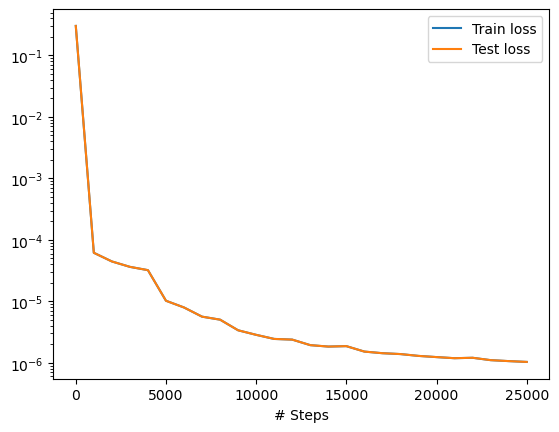

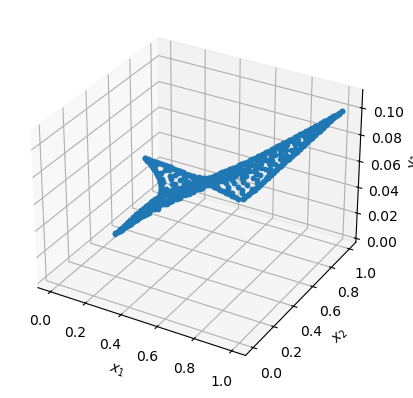

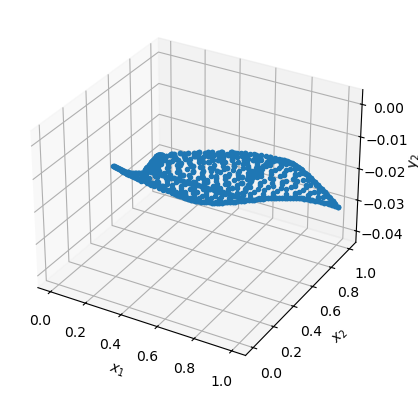

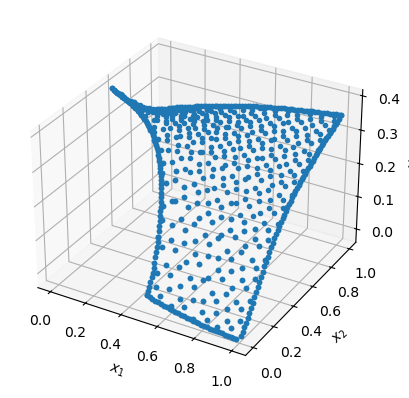

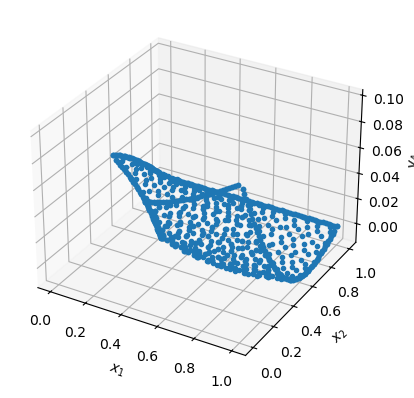

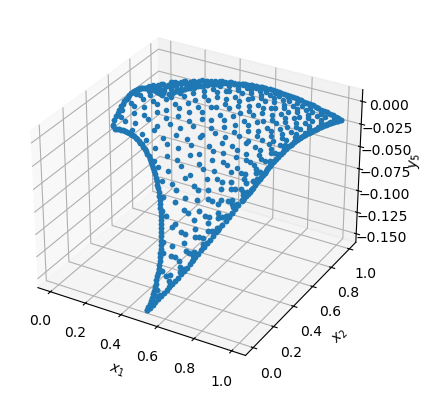

In [65]:
model.train(iterations=5000)
model.compile("adam", lr=0.0001, loss_weights=loss_weights)
model.train(iterations=10000)
model.compile("adam", lr=0.00001, loss_weights=loss_weights)
losshistory, train_state = model.train(iterations=10000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

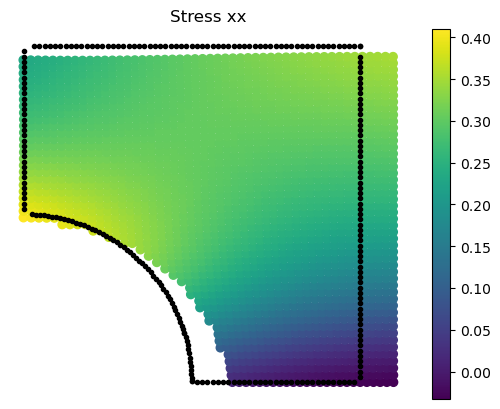

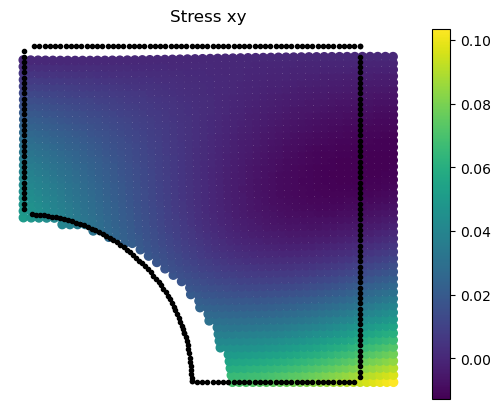

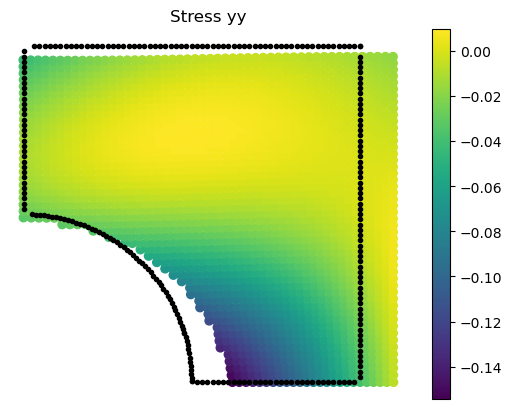

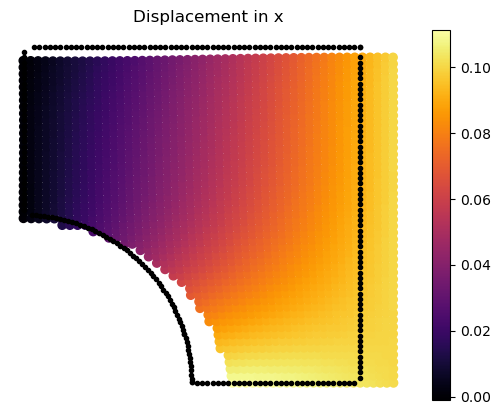

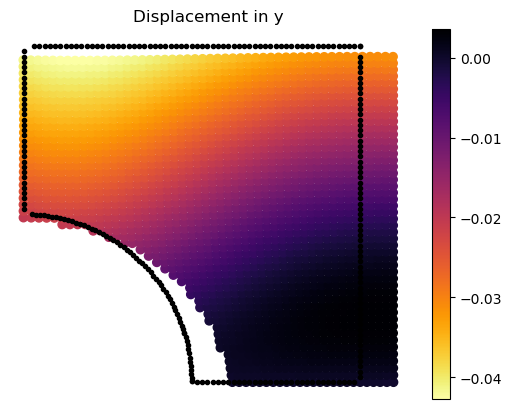

In [66]:
# Create a validation domain different from the training domain
val_x, val_y = np.meshgrid(np.linspace(0, L, 50), np.linspace(0, L, 50))
val = np.vstack([val_x.ravel(), val_y.ravel()]).T
val = val[(val[:,0] ** 2 + val[:,1] ** 2) > R**2]

# Compute model predictions on the validation domain
results = model.predict(val)
disp = results[:, 0:2]
def_val = val + disp


def make_plot(variable, title, **kwargs):
    boundary = data.bc_points()
    plt.plot(boundary[:,0], boundary[:,1], ".k")
    plt.scatter(*def_val.T, c=variable, **kwargs)
    plt.axis("equal")
    plt.axis("off")
    plt.colorbar()
    plt.title(title)
    plt.show()


make_plot(results[:, 2], "Stress xx")
make_plot(results[:, 3], "Stress xy")
make_plot(results[:, 4], "Stress yy")
make_plot(disp[:, 0], "Displacement in x", cmap="inferno")
make_plot(disp[:, 1], "Displacement in y", cmap="inferno_r")